# makemore part 3: Activations & Gradients, BatchNorm

## What is makemore?

Makemore "makes more" of things that you give it. Example uses `names.txt` and makemore learns to make names

Under the hood, makemore is a character-level language model: it treats each line as sequences of individual characters. Model sequence of characters and try to predict next characters in a sequence.

This class will look at 
1. Bigram (one character simply predicts a next one with a lookup table of counts)
2. ~~Bag of Words~~
   1. The table explodes! We'll skip
3. **Multilayer Perceptron**
4. Recurrent Neural Network
5. GRU
6. Transformers

Will build a transformer equivalent to GPT-2, at the level of characters

## Agenda
Characters
Words
Images

---

## External Resources

### Lesson

[Building makemore part 3 (Activations, Gradients, BatchNorm: behind the scenes for MLP) (youtube)](https://www.youtube.com/watch?v=P6sfmUTpUmc)

___

## Import necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

---

In [2]:
# read in all the words
names_data = '../../data/raw/names.txt'

words = open(names_data, 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i  in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset but via a function instead
block_size = 3 # context length: how many characters do we take to predict the next one?
    
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0 /  200000: 24.0032


  10000 /  200000: 2.3854
  20000 /  200000: 2.0962
  30000 /  200000: 2.2542
  40000 /  200000: 2.4621
  50000 /  200000: 2.2587
  60000 /  200000: 2.2272
  70000 /  200000: 2.7387
  80000 /  200000: 2.7177
  90000 /  200000: 2.3498
 100000 /  200000: 2.5120
 110000 /  200000: 1.8544
 120000 /  200000: 2.1249
 130000 /  200000: 1.9540
 140000 /  200000: 1.7832
 150000 /  200000: 2.5655
 160000 /  200000: 2.1913
 170000 /  200000: 1.7836
 180000 /  200000: 1.9174
 190000 /  200000: 2.1057


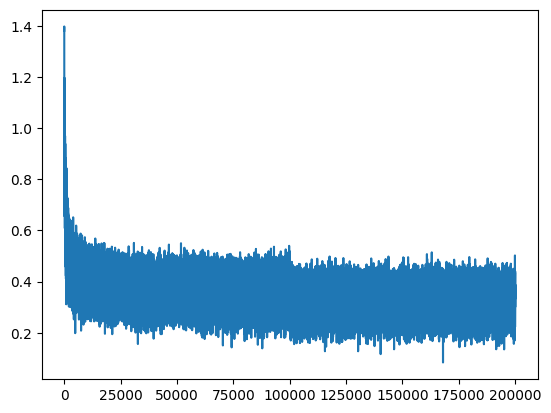

In [10]:
plt.plot(lossi);

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.127918243408203
val 2.164121150970459


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) #decode and print the generated word

mora.
mayah.
see.
madhayla.
reish.
jendrami.
adered.
elin.
shyloe.
leigh.
estanar.
kayziquetra.
noshubergahimiest.
jairenellonnie.
casu.
zen.
dariyah.
fael.
yuma.
myston.


Scrutinizing the model:

1. Something is off with the initialization. Looking at the initial loss, it's way up at 24 and quickly drops to ~2. However, in our case, we already have a rough base case for loss that we should be better than. We can guess uniform distribution for all characters, so the probability should be 1/27, which we can take the log off and then the negative

In [13]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

So at initialization, our model is very confident about some values but wrong. If we look up, we can see that we're initializing a lot of values to be random numbers, but it would be better if the logits were much closer to 0

In [16]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


While it's ok to make a bias vector 0, you should not make a weight matrix 0! 

In [25]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break
    

      0 /  200000: 2.2182


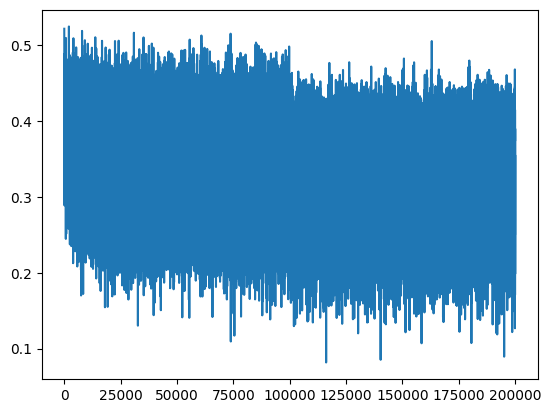

In [19]:
plt.plot(lossi);

Before, we were wasting epochs squashing down weights and getting out of the hockey stick loss. Hockey stick loss is a sign that we didn't start in a good spot

In [20]:
split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310744285583496


Other problem has to do with the activation layer. In the video, he shows that many of them are +-1

In [21]:
h.shape

torch.Size([1, 200])

In [22]:
h.view(-1)

tensor([ 0.7262,  0.9775,  0.5598,  1.0000, -0.9962, -1.0000,  0.9365, -1.0000,
         1.0000, -0.4883, -0.9554,  0.0279, -0.9982,  1.0000, -0.9560,  0.9772,
        -1.0000, -1.0000, -1.0000,  1.0000, -0.9579, -0.9984,  1.0000,  0.9997,
         1.0000, -0.9734, -0.0395, -0.9973, -0.9999, -0.9826, -0.9992, -0.8807,
         0.9987, -0.6131,  0.9947, -1.0000,  0.7077, -0.9800,  0.9920,  0.5423,
         1.0000, -0.7481, -0.9961, -1.0000,  0.7288,  0.9907, -1.0000, -0.5859,
         0.8137, -0.9999, -0.8510, -0.4017, -1.0000, -1.0000, -1.0000, -0.9999,
         0.9499,  0.9926,  0.9815,  0.4341, -0.9996,  0.9902, -0.9746, -1.0000,
        -0.9998, -0.5443,  0.8327,  0.8422,  0.9970,  1.0000,  0.6598,  0.9997,
        -1.0000, -0.9711,  0.9996, -0.9852,  1.0000,  0.9998,  1.0000, -1.0000,
         1.0000, -0.4815, -1.0000, -0.9999,  1.0000, -1.0000, -0.2466, -0.9038,
        -0.9972,  1.0000,  0.9999,  1.0000, -1.0000, -0.9918, -1.0000,  0.9897,
         0.9151, -0.9997, -0.9887, -1.00

In [23]:
h.view(-1).tolist()

[0.7261503338813782,
 0.9775148034095764,
 0.5598186254501343,
 0.9999521970748901,
 -0.9962388873100281,
 -0.9999974370002747,
 0.9365325570106506,
 -0.9999987483024597,
 0.9999988079071045,
 -0.4883185923099518,
 -0.9553890824317932,
 0.027904953807592392,
 -0.9982215762138367,
 0.9999987483024597,
 -0.9559869766235352,
 0.9771846532821655,
 -0.9999982714653015,
 -0.9999521970748901,
 -0.9999933242797852,
 1.0,
 -0.9578964710235596,
 -0.9984109401702881,
 0.9999926686286926,
 0.9996953010559082,
 0.999984622001648,
 -0.9734399914741516,
 -0.039490535855293274,
 -0.9972628355026245,
 -0.9999091625213623,
 -0.98261958360672,
 -0.9991587996482849,
 -0.8807380795478821,
 0.9987007975578308,
 -0.6131216883659363,
 0.9946566820144653,
 -0.9999745488166809,
 0.7077125310897827,
 -0.9800422787666321,
 0.9919869303703308,
 0.5422975420951843,
 0.9999785423278809,
 -0.7481383681297302,
 -0.9961287379264832,
 -1.0,
 0.728832483291626,
 0.9906861186027527,
 -0.9999534487724304,
 -0.5858519673347

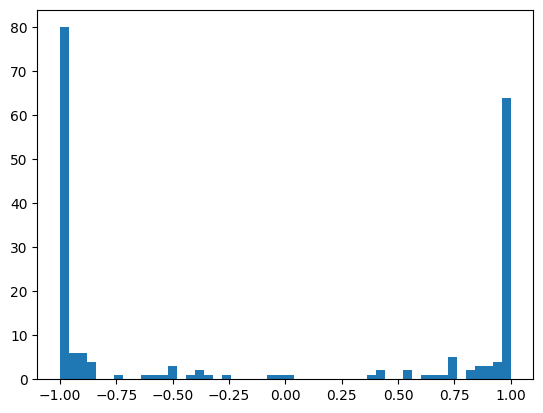

In [24]:
plt.hist(h.view(-1).tolist(), 50);

Tanh should squash values to fall between -1 and +1, but most of them being on the extremes is a problem

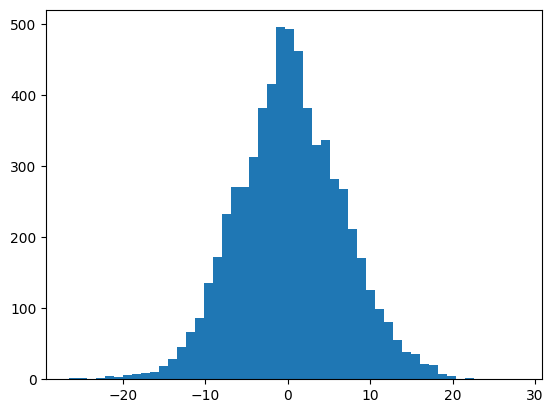

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50);

We see here that the values are broad, and that's why everything is getting squashed to -1 and +1

This is a problem because of how back propagation works: values close to 1 for tanh mean that the backprop calculation is essentially zero and removes any change from the gradient

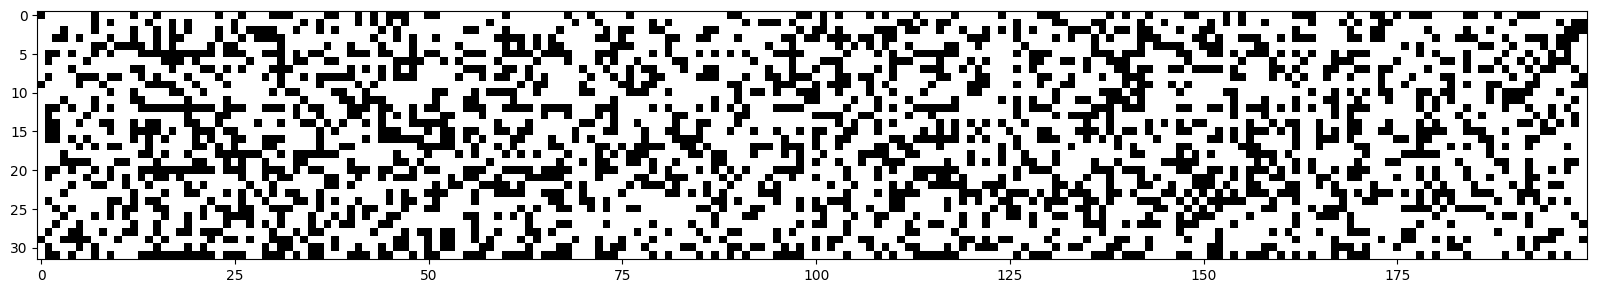

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

A lot of these squares are white, which means that tanh is very active and in the flat tails near +-1. If an entire column is white, that is a dead neuron (it will never learn). Since there aren't any dead neurons, some gradients do flow through.

Neurons can be dead by the initializations OR if the learning rate is too high and a neuron gets knocked out because they have too much of a gradient.

In this specific case, we can let the neural net optimize, even though this isn't optimal

Ideally, hpreact should be close to 0

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break
    

      0 /  200000: 3.3069


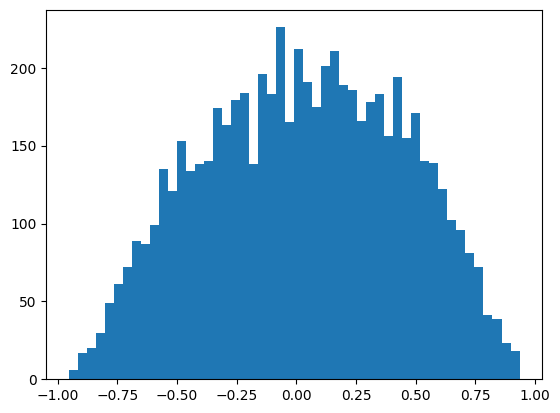

In [31]:
plt.hist(h.view(-1).tolist(), 50);

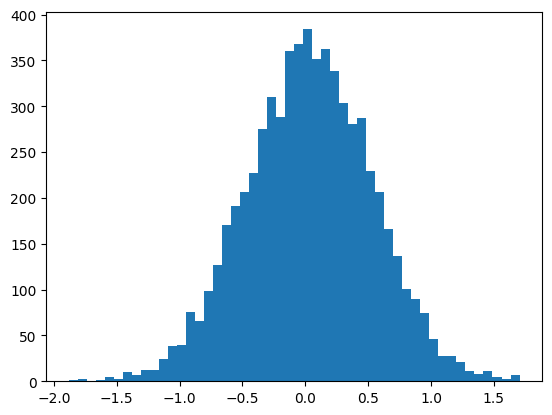

In [32]:
plt.hist(hpreact.view(-1).tolist(), 50);

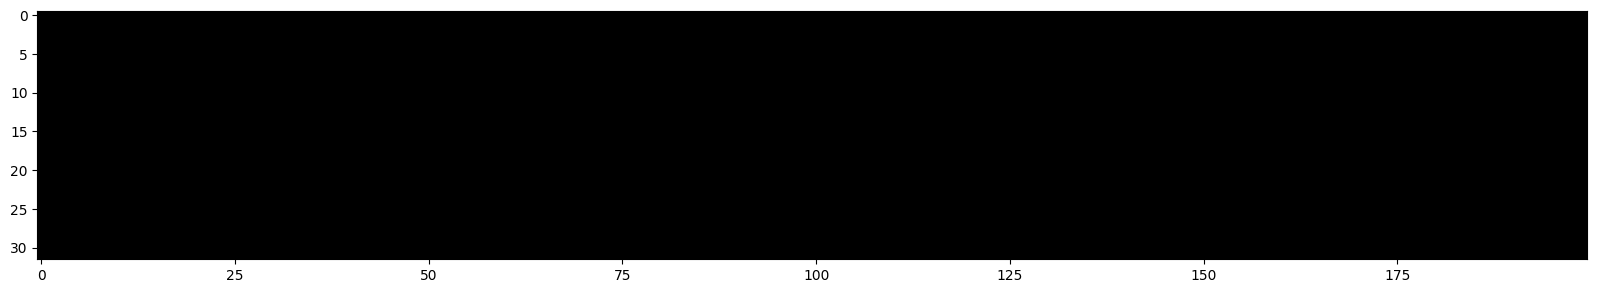

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [34]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break
    

      0 /  200000: 3.3135
  10000 /  200000: 2.1648
  20000 /  200000: 2.3061
  30000 /  200000: 2.4541
  40000 /  200000: 1.9787
  50000 /  200000: 2.2930
  60000 /  200000: 2.4232
  70000 /  200000: 2.0680
  80000 /  200000: 2.3095
  90000 /  200000: 2.1207
 100000 /  200000: 1.8269
 110000 /  200000: 2.2045
 120000 /  200000: 1.9797
 130000 /  200000: 2.3946
 140000 /  200000: 2.1000
 150000 /  200000: 2.1948
 160000 /  200000: 1.8619
 170000 /  200000: 1.7809
 180000 /  200000: 1.9673
 190000 /  200000: 1.8295


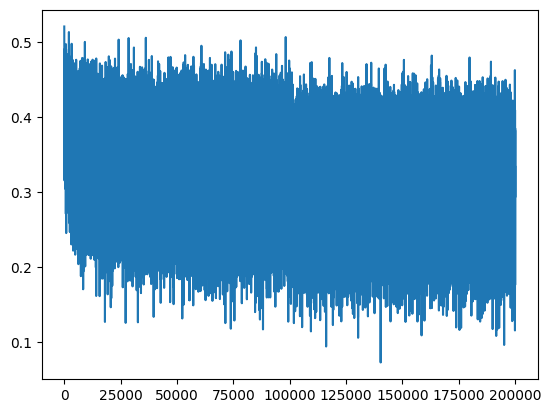

In [36]:
plt.plot(lossi);

In [37]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


How were the magic numbers used to scale down W1, b1, W2, and b2 determined?

tensor(0.0064) tensor(1.0034)
tensor(-0.0006) tensor(3.2083)


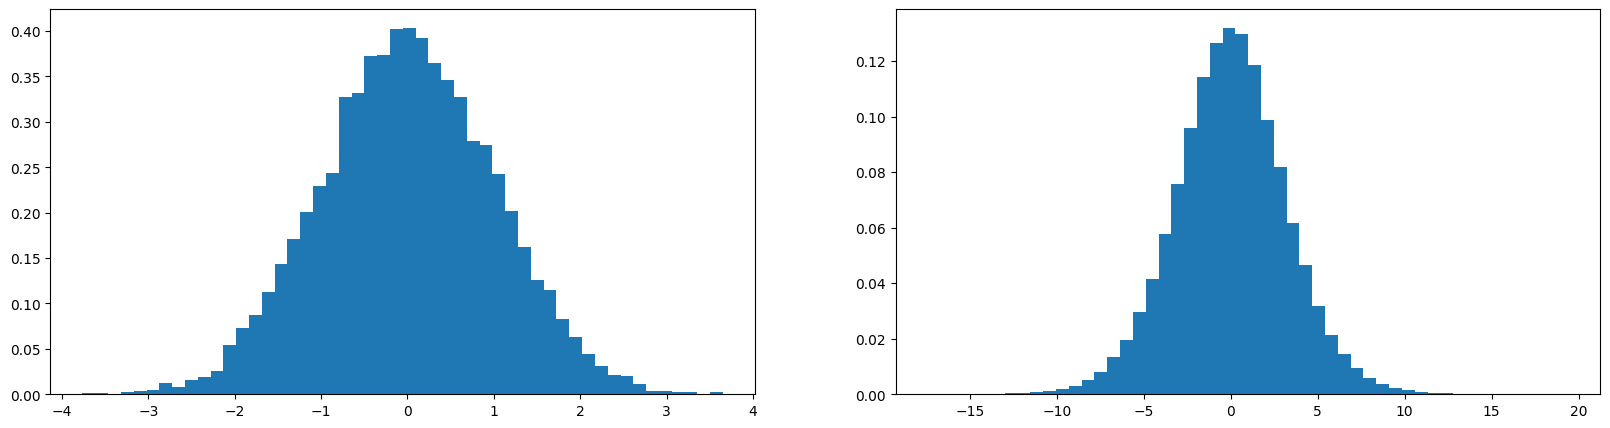

In [41]:
x = torch.randn(1000,10)
w = torch.randn(10, 200)
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

playing with the values/spread for w messes with y a lot and we want y to have a standard deviation ~1

Turns out, math has shown that we can divide by the square root of the "fan in" for w, which here is 10, for best control to keep y under control

There's a paper by Kaiming He referenced, and it turns out this is implemented in PyTorch and likely the most common way to initialize tensors now.

In addition, as time has gone on, there have been other improvements that put less importance on initializing perfectly (eg, residual connections, normalization layers, better optimizers).

In practice, Andrej initializes with the sqrt(fan in)

For us, that means

In [43]:
(5/3) / ((n_embd * block_size)**0.5)

0.3042903097250923

This becomes our coefficient for W1

In [44]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [45]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())   

      0 /  200000: 3.3179
  10000 /  200000: 2.1910
  20000 /  200000: 2.3270
  30000 /  200000: 2.5396
  40000 /  200000: 1.9468
  50000 /  200000: 2.3331
  60000 /  200000: 2.3852
  70000 /  200000: 2.1173
  80000 /  200000: 2.3159
  90000 /  200000: 2.2010
 100000 /  200000: 1.8591
 110000 /  200000: 2.0881
 120000 /  200000: 1.9389
 130000 /  200000: 2.3913
 140000 /  200000: 2.0949
 150000 /  200000: 2.1458
 160000 /  200000: 1.7824
 170000 /  200000: 1.7249
 180000 /  200000: 1.9751
 190000 /  200000: 1.8614


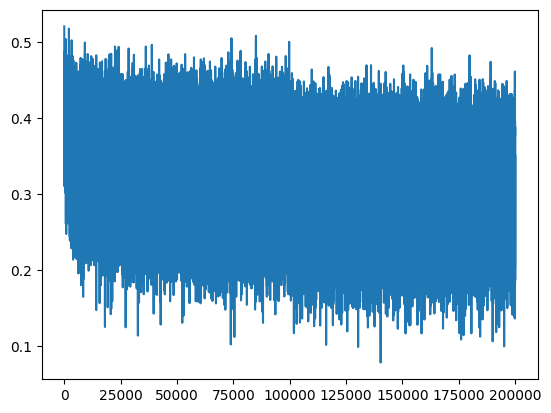

In [46]:
plt.plot(lossi);

In [47]:
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


## Demoing BatchNormalization

Make the pre-activations roughly unit Gaussian, because there's actually technically wrong with doing that

In [48]:
hpreact.shape

torch.Size([32, 200])

In [49]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
loss = -probs[torch.arange(32), Y].log().mean()
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # hidden layer pre-activation
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

Initializing to unit Gaussian is fine, but should not force that to happen every epoch

In [53]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [54]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3147


  10000 /  200000: 2.1984
  20000 /  200000: 2.3375
  30000 /  200000: 2.4359
  40000 /  200000: 2.0119
  50000 /  200000: 2.2595
  60000 /  200000: 2.4775
  70000 /  200000: 2.1020
  80000 /  200000: 2.2788
  90000 /  200000: 2.1862
 100000 /  200000: 1.9474
 110000 /  200000: 2.3010
 120000 /  200000: 1.9837
 130000 /  200000: 2.4523
 140000 /  200000: 2.3839
 150000 /  200000: 2.1987
 160000 /  200000: 1.9733
 170000 /  200000: 1.8668
 180000 /  200000: 1.9973
 190000 /  200000: 1.8347


In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


Typically, we add a batch normalization layer after a linear layer

However, there is a cost associated with making this layer; h and logits end up becoming dependent on other inputs in both forward and backward pass. Accidentally causes regularization

With Batch Normalization, inference becomes harder. Easiest way is to do the following

In [56]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [57]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation


    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3147
  10000 /  200000: 2.1984
  20000 /  200000: 2.3375
  30000 /  200000: 2.4359
  40000 /  200000: 2.0119
  50000 /  200000: 2.2595
  60000 /  200000: 2.4775
  70000 /  200000: 2.1020
  80000 /  200000: 2.2788
  90000 /  200000: 2.1862
 100000 /  200000: 1.9474
 110000 /  200000: 2.3010
 120000 /  200000: 1.9837
 130000 /  200000: 2.4523
 140000 /  200000: 2.3839
 150000 /  200000: 2.1987
 160000 /  200000: 1.9733
 170000 /  200000: 1.8668
 180000 /  200000: 1.9973
 190000 /  200000: 1.8347


In [58]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [59]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5731,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0112,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0389,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [60]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0698, -0.0781,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2400,  2.0104,  0.6695,  0.0768, -0.0851, -1.6768,  0.2963,
          2.2374, -0.0100, -0.6670,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

In [61]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # hidden layer pre-activation
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation


    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

When using Batch Normalization, layer by layer bias gets canceled out since BatchNorm has its own bias

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # linear layer
    hpreact = embcat @ W1 # hidden layer pre-activation
    
    # BatchNorm layer
    # this layer usually comes after any layer with multiplications
    # like a linear layer or a convolutional layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias 
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

In [ ]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

In [ ]:
logits

In [ ]:
logits.max(1)

Repeat above, but now train on the entire dataset instead of the first 5 names

In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

I interrupted the previous cell because each iteration takes a while, and Andrej comments on this as well! He mentions that in real situations, we can't train on all data at once, and we take mini batches and train on those.

In [ ]:
torch.randint(0,X.shape[0],(32,))

In [ ]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())


SO FAST!

Minibatches are much much faster, but the quality of gradient is not as good. However, you take so many batches that are generally good enough that it's better to minibatch with more steps

In [ ]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

For next time, start at 45:53, we are trying to find a good learning rate. How? Messing around for this example shows it's between 0.001 and 1

In [ ]:
torch.linspace(0.001, 1, 1000) #creates 1000 numbers between 0.001 and 1
# however, this doesn't really make any sense as it's too fine

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# here we're going 10 to the power of as these make more sense

In [ ]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())

# print(loss.item())


In [ ]:
plt.plot(lri, lossi);

Looks like it's pretty good at around 0.1!

In [ ]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for _ in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

Loss keeps going down, but remember to watch out for over fitting!

In [ ]:
# training split, dev/validation split, test split
# usually used for training parameters, training hyperparameters, evaluate the model
# 80 / 10 / 10
# test loss sparingly!

In [ ]:
# build the dataset but via a function instead

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
Xtr.shape, Ytr.shape #dataset

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for i in range(35000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())
    
print(loss.item())

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

Since the training and dev losses are roughly equal, we are not overfitting the training data. We think we can improve the model but increasing the size of the neural net!

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

In [ ]:
lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(35000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.item())
    stepi.append(i)
    
# print(loss.item())

In [ ]:
plt.plot(stepi, lossi);

The thickness in the plot is due to us using minibatches, which creates some noise

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

Want to do more training, but it's possible that we only see noise. Fix is to increase the size of the minibatches to lower the amount of thrashing about and truly optimize the parameters/hyper parameters

In the video, the loss isn't decreasing that much despite using more layers. We may be starting with embeddings that aren't helpful enough. Too many characters getting mashed into 2 dimensions

In [ ]:
lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(100000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.item())
    stepi.append(i)
    
# print(loss.item())

In [ ]:
plt.plot(stepi, lossi);

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200);
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

The plot allows you to see if there's any sort of clustering or structure in the embeddings. In the video (which had a longer trained model), the vowels were clustered pretty close together, implying that they are interchangeable. q and . were separate from the other characters.

We'll change the embedding dimension to more than 2, but this means we can't visualize as easily

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for p in parameters:
    p.requires_grad = True

for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    
# print(loss.item())

In [ ]:
plt.plot(stepi, lossi);

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    

In production, we would create hyperparamters and run experiments on all these settings

In [ ]:
plt.plot(stepi, lossi);

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

These are slowly starting to deviate.

There's a few more minutes of trying to get the log loss below 2

How to improve?
1. Change number of neurons in the hidden layer
2. Change dimensionality of embedding/lookup table
3. Change number of characters being fed in as context
4. Change number of steps, learning rate, batch size
5. Read the paper that's cited!